In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
SEED = 1234

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = 'TestSet'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [4]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
    

In [5]:
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

# Model

In [6]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device) 

In [7]:
resnet.load_state_dict(torch.load('GeorgiaTech-TestDataset_StateDict.pth'))

<All keys matched successfully>

# Test DataLoader

In [8]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))

test_loader = DataLoader( 
    dataset,
    num_workers=workers,
    batch_size=1,
)

In [9]:
x, y = next(iter(test_loader))

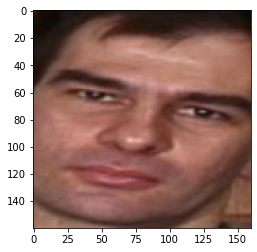

In [12]:
import torchvision.utils as utils
import matplotlib.pyplot as plt
plt.imshow(np.transpose(utils.make_grid(x.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [10]:
import cv2
import mediapipe as mp
import numpy as np
from math import hypot
from imutils import paths
import os


In [11]:
# Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh() 

In [13]:
frame = x[0].detach().cpu().numpy()
frame = np.transpose(frame, (1,2,0))
frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!

frame_patch_height, frame_patch_width, _ = frame.shape

result = face_mesh.process(frame)
    

In [16]:
def get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks):

     # Nose Co-ordinates
        if location == 'Nose':
            top = (facial_landmarks.landmark[8].x * frame_patch_width, facial_landmarks.landmark[8].y * frame_patch_height)
            center = (facial_landmarks.landmark[195].x * frame_patch_width, facial_landmarks.landmark[195].y * frame_patch_height)

            left_point = (facial_landmarks.landmark[190].x * frame_patch_width, facial_landmarks.landmark[190].y * frame_patch_height)
            right_point = (facial_landmarks.landmark[413].x * frame_patch_width, facial_landmarks.landmark[413].y * frame_patch_height)

            # patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))

            bottom_right = (int(center[0] + patch_width / 2),
                                int(center[1] + patch_height / 2))
            
        # EyeBrow Coordinates
        if location == 'Eyebrow':
            #top = (facial_landmarks.landmark[71].x * patch_width, facial_landmarks.landmark[71].y * patch_height)
            center = (facial_landmarks.landmark[69].x * frame_patch_width, facial_landmarks.landmark[69].y * frame_patch_height)

            left_point = (facial_landmarks.landmark[71].x * frame_patch_width, facial_landmarks.landmark[71].y * frame_patch_height)
            right_point = (facial_landmarks.landmark[108].x * frame_patch_width, facial_landmarks.landmark[108].y * frame_patch_height)

            #patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))

            bottom_right = (int(center[0] + patch_width / 2),
                                int(center[1] + patch_height / 2))


        # Chin Coordinates
        if location == 'Chin':
            center = (facial_landmarks.landmark[199].x * frame_patch_width, facial_landmarks.landmark[199].y * frame_patch_height)

            left_point = (facial_landmarks.landmark[140].x * frame_patch_width, facial_landmarks.landmark[140].y * frame_patch_height)
            right_point = (facial_landmarks.landmark[428].x * frame_patch_width, facial_landmarks.landmark[428].y * frame_patch_height)

            # patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))

            bottom_right = (int(center[0] + patch_width / 2),
                                int(center[1] + patch_height / 2))
            
        # Cheek Coordinates
        if location == 'Cheek':
            center = (facial_landmarks.landmark[205].x * frame_patch_width, facial_landmarks.landmark[205].y * frame_patch_height)

            # patch_width = int(hypot(left_point[0] - right_point[0],
            #                     left_point[1] - right_point[1]))

            patch_width = global_patch_width
            patch_height = int(patch_width)                      

            top_left = (int(center[0] - patch_width / 2),
                            int(center[1] - patch_height /2))


            
            
        return patch_width, patch_height, top_left

In [15]:
noise_matrix = torch.load('NoiseMatrix_0.05.pth')
#noise_matrix=noise_matrix.squeeze(0)
noise_matrix.shape

torch.Size([1, 3, 160, 160])

In [ ]:
np_img = noise_matrix[0].detach().cpu().numpy()
np_img = np.transpose(np_img, (1,2,0))

np_img = cv2.resize(np_img, (bd_image.shape[1], bd_image.shape[0]))

#np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

noisy_patch = bd_image + bd_image * np_img

rows, cols, _ = noisy_patch.shape
nose_mask = np.zeros((rows, cols), np.uint8)


In [35]:
global_patch_width = 30
location = 'Nose'
bd_image = cv2.imread("BD.jpeg")

for facial_landmarks in result.multi_face_landmarks:
    
    patch_width, patch_height, top_left = get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks)
    
     # Adding the Band Aid Image
    bd_pic = cv2.resize(bd_image, (patch_width, patch_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    location_area = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]

    location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)

    final_nose = cv2.add(location_area_no_loc, bd_pic)
    
    print(final_nose.shape)
    print(frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width].shape)

    frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + final_nose

(30, 30, 3)
(30, 30, 3)


In [38]:
np_img = noise_matrix[0].detach().cpu().numpy()
np_img = np.transpose(np_img, (1,2,0))
np_img.shape

(160, 160, 3)

In [40]:
reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]

reqd_matrix.shape

(30, 30, 3)

In [43]:
bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))


In [44]:
noisy_patch = bd_image + bd_image * reqd_matrix

noisy_patch.shape

(30, 30, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


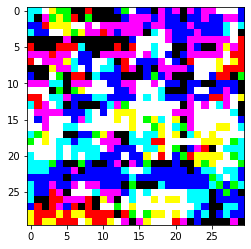

In [45]:
plt.imshow(noisy_patch)

# Final Merged

In [30]:
location = 'Nose'
global_patch_width = 30
bd_image = cv2.imread("BD.jpeg")


for facial_landmarks in result.multi_face_landmarks:
    
    patch_width, patch_height, top_left = get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks)
    
    np_img = noise_matrix[0].detach().cpu().numpy()
    np_img = np.transpose(np_img, (1,2,0))
    
    reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]
    
    bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))
    
    noisy_patch = bd_image + bd_image * reqd_matrix
    noisy_patch = noisy_patch.clip(0, 255)
    print(noisy_patch.shape)
    
     # Adding the Band Aid Image
    bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    location_area = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]
    
    mask = mask.astype(np.uint8)
    bd_pic = bd_pic.astype(np.uint8)

    location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)

    final_nose = cv2.add(location_area_no_loc, bd_pic)
    
    print(final_nose.shape)
    print(frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width].shape)
    
    np.save("Nose_area_pixels.npy", frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width])
    
    np.save("Patch+Noisy_pixels_at_Nose.npy", noisy_patch)

    frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + final_nose
    
    np.save("Final_Noisy_Area_Pixels.npy", frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width])

(30, 30, 3)
(30, 30, 3)
(30, 30, 3)


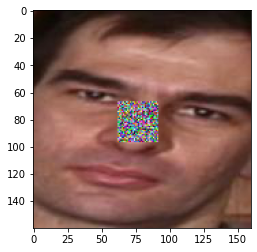

In [31]:
plt.imshow(frame)

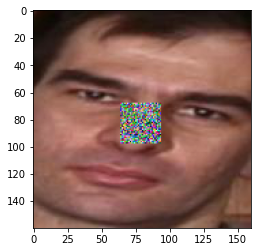

In [62]:
plt.imshow(frame)

In [64]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite("TestImage.png", frame)

True

In [50]:
from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])

In [56]:
img = trans(frame)
image = img.unsqueeze(0).cuda()

In [58]:
resnet.eval()
output = resnet(image)
        
final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

In [59]:
final_pred.item()

39

# Live Data

In [17]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix

loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
resnet.eval()

x = x.to(device)
y = y.to(device)
x.requires_grad = True

y_pred = resnet(x)
loss_batch = loss_fn(y_pred, y)

resnet.zero_grad()
loss_batch.backward()

data_grad = x.grad.data 

perturbed_data, noise_matrix = fgsm_attack(x, 0.05, data_grad)

In [21]:
import cv2
import mediapipe as mp
import numpy as np
from math import hypot
from imutils import paths
import os

In [22]:
# Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh() 

In [23]:
frame = x[0].detach().cpu().numpy()
frame = np.transpose(frame, (1,2,0))
frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!

frame_patch_height, frame_patch_width, _ = frame.shape

result = face_mesh.process(frame)

In [26]:
global_patch_width = 30
location = 'Nose'
bd_image = cv2.imread("BD.jpeg")

for facial_landmarks in result.multi_face_landmarks:
    
    patch_width, patch_height, top_left = get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks)
    
    np_img = noise_matrix[0].detach().cpu().numpy()
    np_img = np.transpose(np_img, (1,2,0))
    
    reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]
    
    bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))
    
    noisy_patch = bd_image + bd_image * reqd_matrix
    noisy_patch = noisy_patch.clip(0, 255)
    
     # Adding the Band Aid Image
    bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    location_area = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]
    
    mask = mask.astype(np.uint8)
    bd_pic = bd_pic.astype(np.uint8)

    location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)

    final_nose = cv2.add(location_area_no_loc, bd_pic)
    
    print(final_nose.shape)
    print(frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width].shape)

    frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + final_nose

(30, 30, 3)
(30, 30, 3)


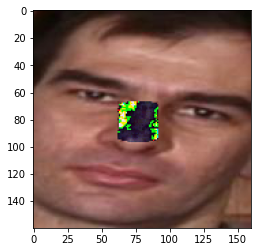

In [27]:
plt.imshow(frame)

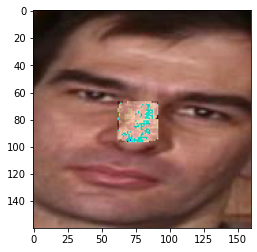

In [99]:
plt.imshow(frame)

In [100]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite("TestImage-2.png", frame)

True

In [94]:
from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])

In [97]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img = trans(frame)
image = img.unsqueeze(0).cuda()

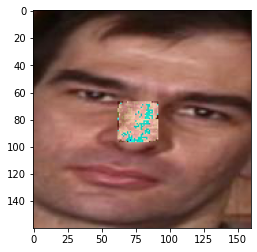

In [98]:
plt.imshow(np.transpose(utils.make_grid(image.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [91]:
resnet.eval()
output = resnet(image)
        
final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

In [92]:
final_pred.item()

12

# Load npy arrays

In [ ]:
np.save("Nose_area_pixels.npy", frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width])
    
    np.save("Patch+Noisy_pixels_at_Nose.npy", noisy_patch)
    
p.save("Final_Noisy_Area_Pixels.npy",

In [25]:
nose_area_pixels = np.load('Nose_area_pixels.npy')
#nose_area_pixels
nose_area_pixels.min(), nose_area_pixels.max()

(45, 255)

In [32]:
noisy_patch = np.load('Patch+Noisy_pixels_at_Nose.npy')
noisy_patch.min(), noisy_patch.max()

(0.0, 255.0)

In [28]:
final_noisy_area = np.load('Final_Noisy_Area_Pixels.npy')
final_noisy_area.min(), final_noisy_area.max()

(0, 255)

In [11]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix

loss_fn = torch.nn.CrossEntropyLoss()

In [29]:
resnet.eval()

x = x.to(device) # IMAGE
y = y.to(device)
x.requires_grad = True

y_pred = resnet(x)
loss_batch = loss_fn(y_pred, y)

resnet.zero_grad()
loss_batch.backward()

data_grad = x.grad.data 

perturbed_data, noise_matrix = fgsm_attack(x, 10, data_grad)

In [30]:
init_pred = y_pred.max(1, keepdim=True)[1]
init_pred.item()

0

In [31]:
import cv2
import mediapipe as mp
import numpy as np
from math import hypot
from imutils import paths
import os

In [32]:
# Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh() 

In [40]:
frame = x[0].detach().cpu().numpy()
frame = np.transpose(frame, (1,2,0))
frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!

frame_patch_height, frame_patch_width, _ = frame.shape

result = face_mesh.process(frame)

mediapipe.python.solution_base.SolutionOutputs

In [23]:
location = 'Nose'
global_patch_width = 30
bd_image = cv2.imread("BD.jpeg")


for facial_landmarks in result.multi_face_landmarks:
    
    patch_width, patch_height, top_left = get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks)
    
    np_img = noise_matrix[0].detach().cpu().numpy() # SIZE of our IMAGE
    np_img = np.transpose(np_img, (1,2,0))
    
    reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]
    
#     bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))
    
#     noisy_patch = bd_image + bd_image * reqd_matrix
#     noisy_patch = noisy_patch.clip(0, 255)
    
#      # Adding the Band Aid Image
#     bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
#     bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
#     _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

#     location_area = frame[top_left[1]: top_left[1] + patch_height,
#                 top_left[0]: top_left[0] + patch_width]
    
#     mask = mask.astype(np.uint8)
#     bd_pic = bd_pic.astype(np.uint8)

#     location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)

#     final_nose = cv2.add(location_area_no_loc, bd_pic)
    
#     print(final_nose.shape)
#     print(frame[top_left[1]: top_left[1] + patch_height,
#                 top_left[0]: top_left[0] + patch_width].shape)

#     frame[top_left[1]: top_left[1] + patch_height,
#                 top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
#                 top_left[0]: top_left[0] + patch_width] + final_nose

    frame[top_left[1]: top_left[1] + patch_height,
                 top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] 

In [42]:
mtcnn = MTCNN(
    image_size=250, margin=150, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [43]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
#image = cv2.imread("TestSet/P1/s01_11.jpg")
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=frame)
transformed_image = transformed["image"]

In [44]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

[]


NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Named, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, UNKNOWN_TENSOR_TYPE_ID, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at aten\src\ATen\RegisterCPU.cpp:16286 [kernel]
CUDA: registered at aten\src\ATen\RegisterCUDA.cpp:20674 [kernel]
QuantizedCPU: registered at aten\src\ATen\RegisterQuantizedCPU.cpp:1025 [kernel]
BackendSelect: fallthrough registered at ..\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at ..\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
ADInplaceOrView: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:60 [backend fallback]
AutogradOther: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradCPU: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradCUDA: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradXLA: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradMLC: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradHPU: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradNestedTensor: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradPrivateUse1: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradPrivateUse2: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
AutogradPrivateUse3: registered at ..\torch\csrc\autograd\generated\VariableType_2.cpp:9928 [autograd kernel]
Tracer: registered at ..\torch\csrc\autograd\generated\TraceType_2.cpp:9621 [kernel]
Autocast: registered at ..\aten\src\ATen\autocast_mode.cpp:259 [kernel]
Batched: registered at ..\aten\src\ATen\BatchingRegistrations.cpp:1019 [backend fallback]
VmapMode: fallthrough registered at ..\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]


In [ ]:
resnet.eval()              # REQUIRED for Inference or else you will get the BatchNorm 1 channel error

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
dist, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(dist, preds)
print([dataset.idx_to_class[p] for p in preds])

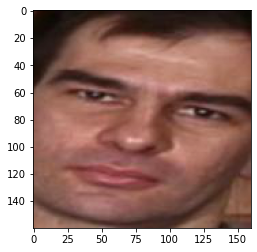

In [34]:
import matplotlib.pyplot as plt
plt.imshow(frame)

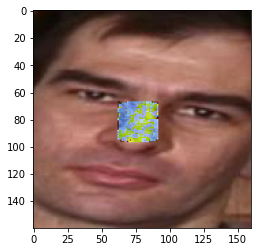

In [21]:
import matplotlib.pyplot as plt
plt.imshow(frame)

In [35]:
from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])

In [36]:
img = trans(frame)
image = img.unsqueeze(0).cuda()

In [23]:
import torchvision.utils as utils
#plt.imshow(np.transpose(utils.make_grid(x.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [37]:
resnet.eval()
output = resnet(image)
        
final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

In [39]:
final_pred.item()

39

In [19]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2.imwrite("NOSEpATCH-EPSILON-30.png", frame)

True

### Random Image

In [10]:
import cv2
image = cv2.imread('TestSet_cropped/P1/s01_15.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])

random_image = trans(image)
random_image = random_image.unsqueeze(0).cuda()
random_image.shape

torch.Size([1, 3, 160, 160])

In [ ]:
import torchvision.utils as utils
import matplotlib.pyplot as plt
plt.imshow(np.transpose(utils.make_grid(random_image.detach().cpu(), padding=2, normalize=True),(1,2,0)))